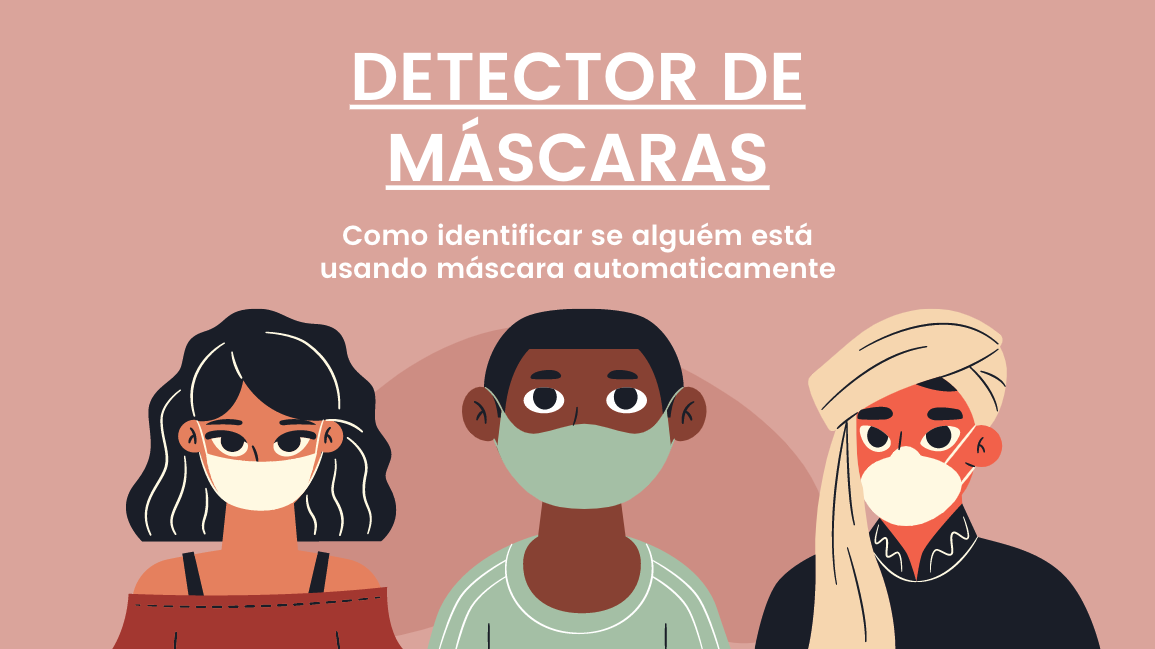


# Detector de Máscaras

Em meio à crise da Covid-19, o uso de máscaras faciais se tornou uma forma de proteção contra o vírus.
No entanto, não existem evidências científicas de que as máscaras faciais protejam completamente a pessoa que as usa.
O nosso projeto da disciplina de Deep Learning (2/2020) tem o objetivo de criar um detector de máscaras utilizando técnicas ensinadas no semestre.

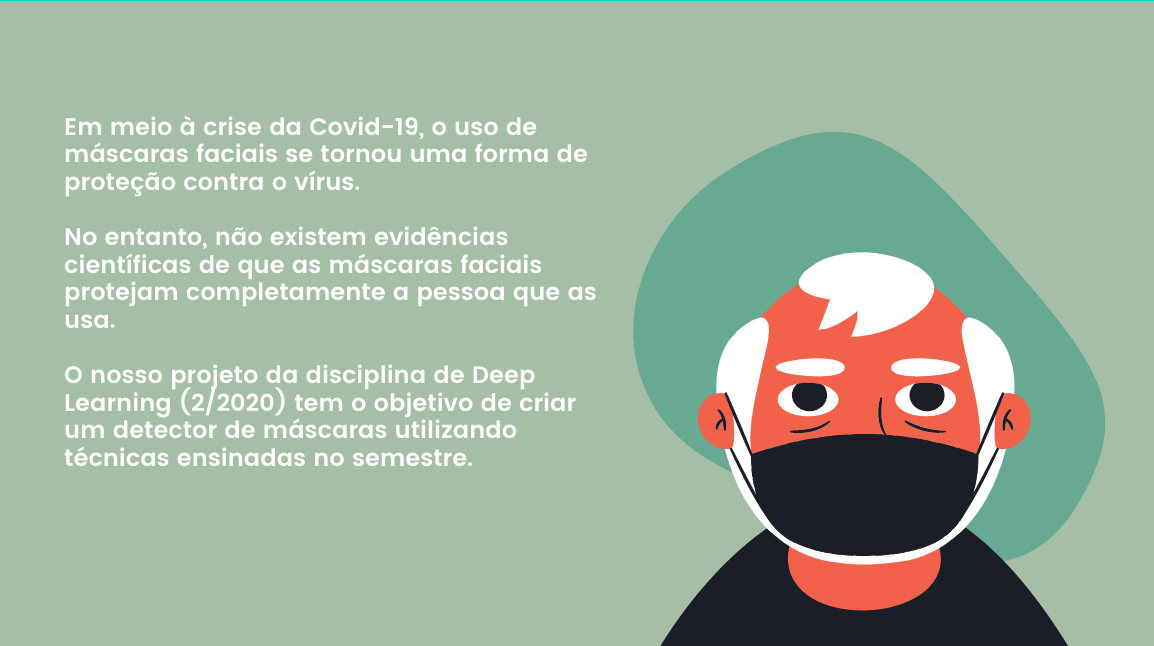

### Membros

|Nome|Matricula|Github|
|--|--|--|
|Ana Carolina Carvalho da Silva|190063441|[AnaCarolcs](https://github.com/AnaCarolcs)|
|Lucas da Cunha Andrade|180105256|[nYCSTs](https://github.com/nYCSTs)|
|Matheus Gabriel Alves Rodrigues|180106970|[Matheus73](https://github.com/Matheus73)|

## Etapas do projeto

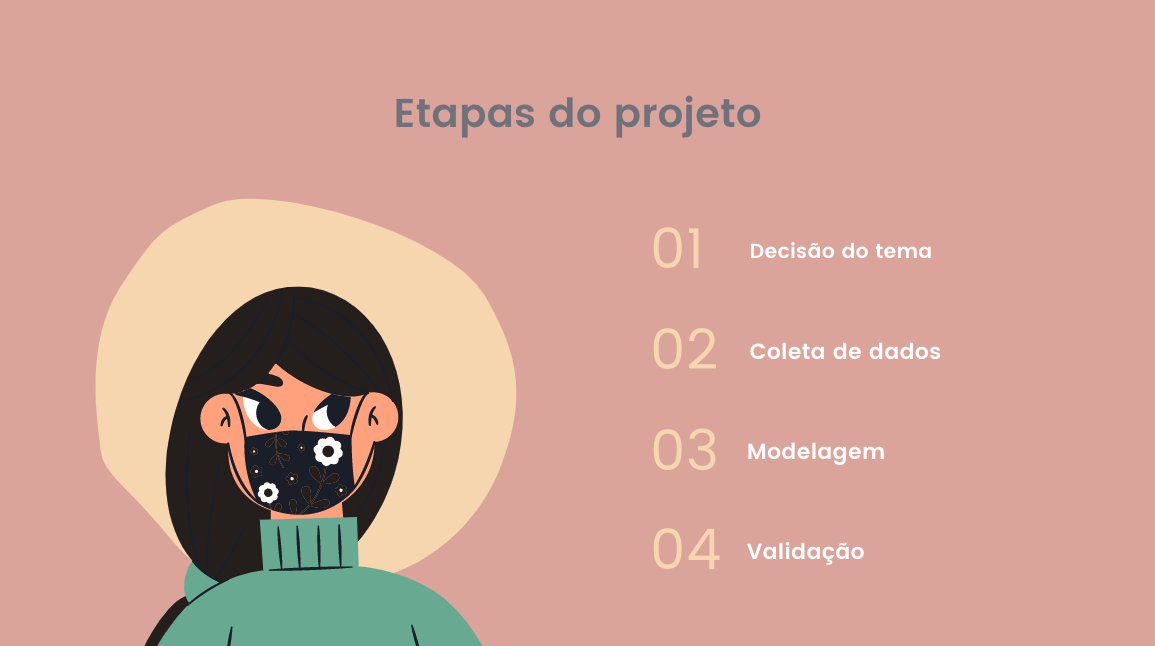

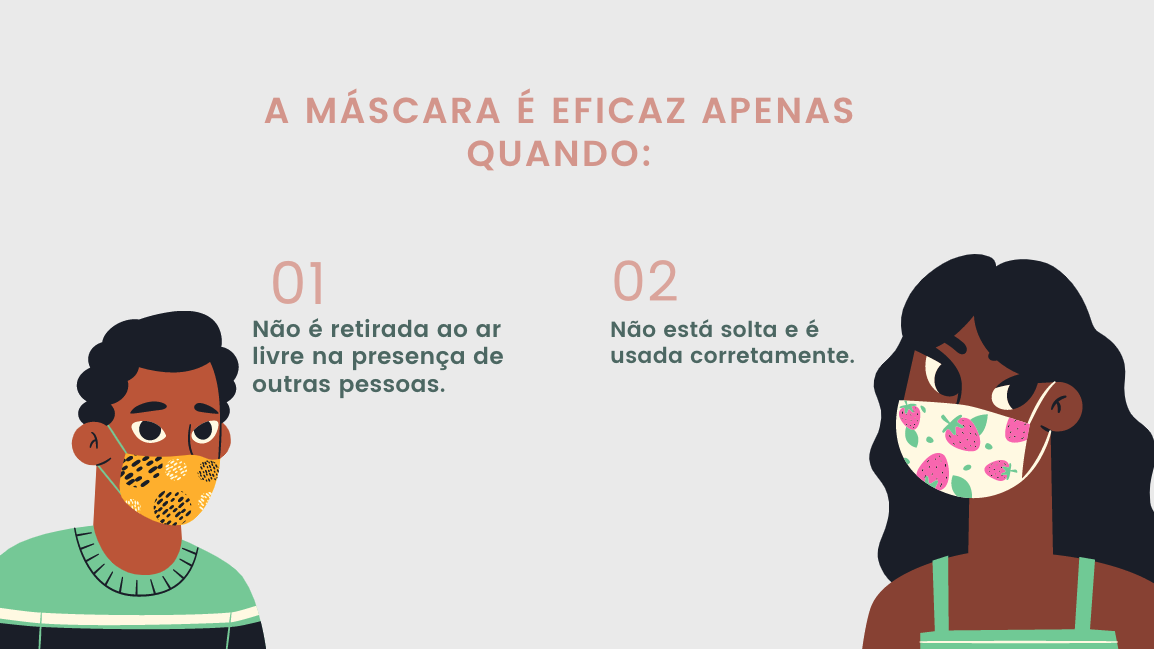

## Coleta de dados

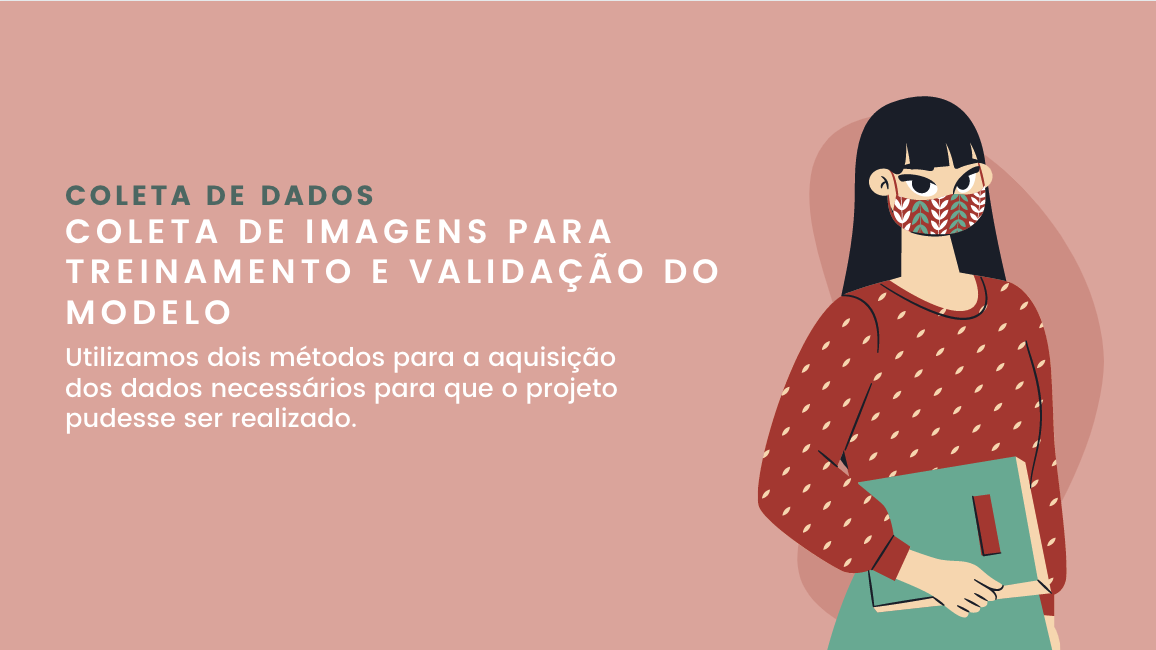

Essa etapa consitiu na coleta de imagens para treinamento e validação do modelo, tendo sido adotadas vários métodos para a aquisição desses dados, esses métodos foram:

### Web scrapping

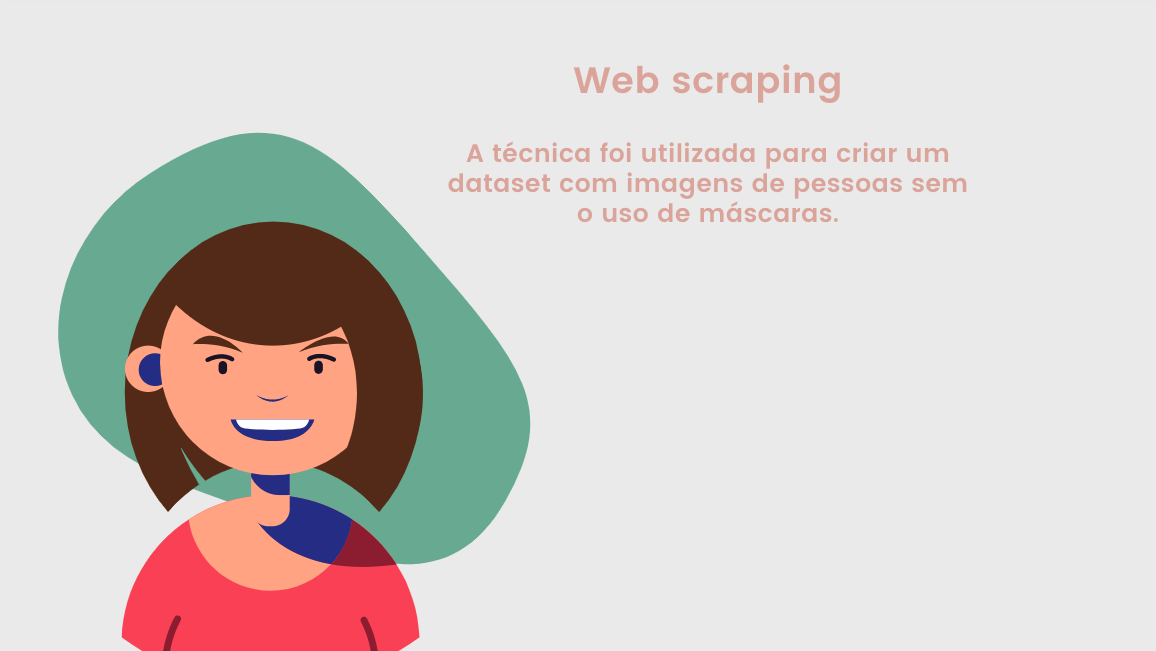

Coletadas imagens de pessoas sem o uso de máscaras e adicionado o objeto num pre-processamento (Tudo automatizado)

##### Coleta das imagens

Fonte: [thispersondoesnotexist.com/](https://thispersondoesnotexist.com/)

In [2]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time 

driver = webdriver.Chrome('./chromedriver')
driver.get('https://thispersondoesnotexist.com/')


for i in range(0, 400):
    try:
        driver.find_element_by_xpath('//*[@id="face"]').screenshot('/home/matheus/Documents/Study/Data science/detect_glasses/nomask/personnotexist'+str(i+100)+').png')
        driver.refresh()
    except:
        pass


WebDriverException: Message: 'chromedriver' executable needs to be in PATH. Please see https://sites.google.com/a/chromium.org/chromedriver/home


### Adicionando as máscaras

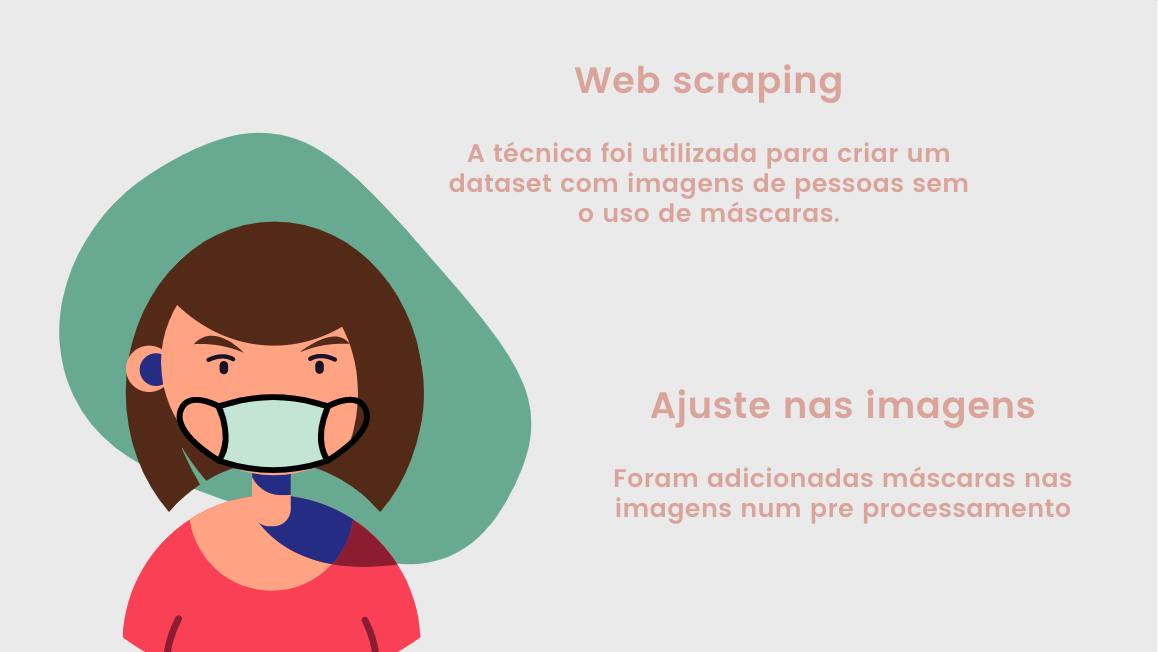

In [3]:
import os
import random
from PIL import Image

parent_dir = 'nomask/'

masks = ['mask1.png', 'mask2.png', 'mask3.png', 'mask4.png']

for subdir, dirs, files in os.walk(parent_dir):
    for count, file in enumerate(files):
        image_path = os.path.join(subdir, file)
        img = Image.open(image_path)

        img2 = img.copy()
        mask = Image.open(random.choice(masks))

        img.paste(mask,(0,0),mask)
        img.save(f"withmask/withMask{count}.png")


#### Resultados Obtidos

<img src='https://raw.githubusercontent.com/deeplearningunb/Detector-de-mascara/main/data/training_images/withMask/withMask133.png' width=300px heigth=300px>

### Base de dados encontrada

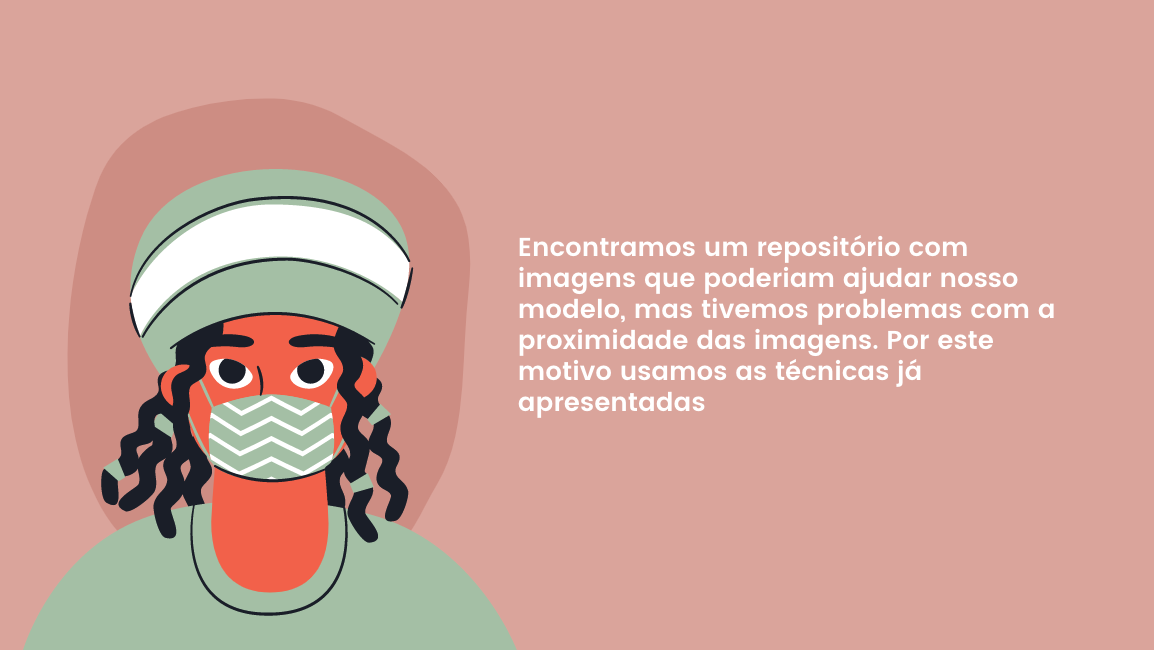

Examplo:

<img src='https://raw.githubusercontent.com/deeplearningunb/Detector-de-mascara/main/data/training_images/withMask/91.jpg' width=300px heigth=300px>


**Problema com a proximidade das imagens**

### Coleta manual

Para corrigir o problema do modelo buscamos manualmente imagens de pessoas mais distantes

<img src='https://raw.githubusercontent.com/deeplearningunb/Detector-de-mascara/main/data/training_images/withMask/91comMascara.png' width=300px heigth=300px>


## Modelagem 

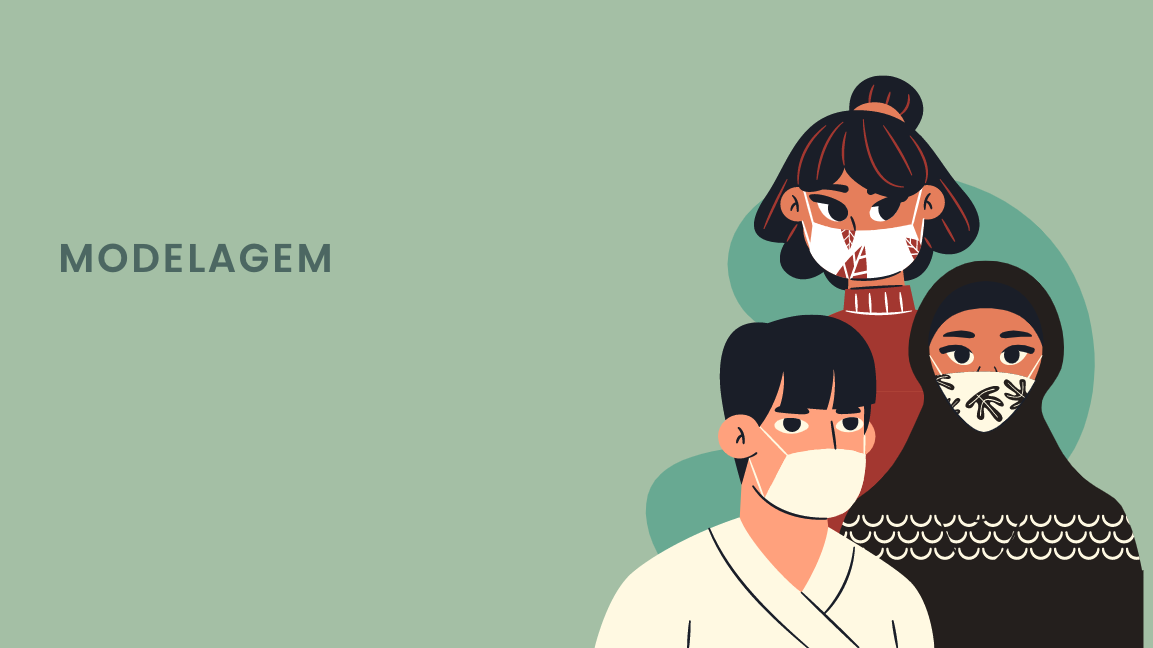

In [4]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

training_set = train_datagen.flow_from_directory('data/training_images',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binfaary')

test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory('data/test_images',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

cnn = tf.keras.models.Sequential()

cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))

cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

cnn.fit(x = training_set, validation_data = test_set, epochs = 15)

cnn.save('mask_detector_model')


ValueError: Invalid class_mode: binfaary; expected one of: {None, 'binary', 'categorical', 'sparse', 'input'}

## Aplicação

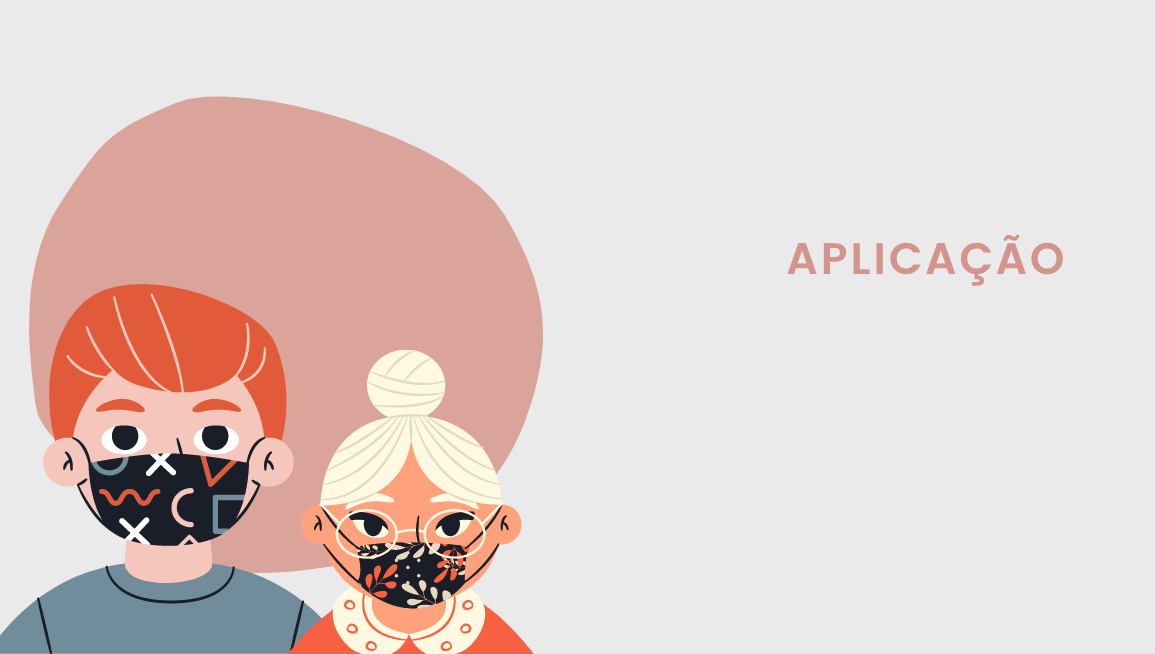

In [5]:
import cv2 as cv
import os
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import numpy as np
from keras.preprocessing import image

cam = cv.VideoCapture(0)

cnn = keras.models.load_model('mask_detector_model')

while True:
    status, frame = cam.read()

    if not status:
        break

    if cv.waitKey(1) & 0xff == ord('q'):
        break

    cv.imwrite('frame.png',frame)

    test_image = image.load_img('frame.png', target_size = (64, 64))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = cnn.predict(test_image)
    if result[0][0] == 1:
        prediction = 'COM mascara'
        cv.rectangle(frame,(150,15),(500,85),(255,255,255), -1)
        cv.putText(frame,prediction,(0 + 200,0 + 0 + 50), cv.FONT_HERSHEY_COMPLEX,1, (56,142,72), 2, cv.LINE_AA)
    else:
        prediction = 'SEM mascara'
        cv.rectangle(frame,(150,15),(500,85),(255,255,255), -1)
        cv.putText(frame,prediction,(0 + 200,0 + 0 + 50), cv.FONT_HERSHEY_COMPLEX,1,(0,40,255) , 2, cv.LINE_AA)

    cv.imshow("Screen",frame)


ModuleNotFoundError: No module named 'cv2'